### Recommended literature for FRESEAN mode analysis

M. A. Sauer & M. Heyden, *J. Chem. Theory Comput.* **2023**, 19, 5481-5490.

### Import modules

In [1]:
import os
import urllib.request
# numpy makes python fast
import numpy as np
# MDAnalysis provides an interface to many topology and trajectory formats
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis.rms import rmsd
# tqdm gives us progress bars
from tqdm import *
# Fourier transforms from scipy
from scipy.fft import fft, ifft
# matplotlib for plotting
import matplotlib.pyplot as plt
# custom modules (included)
import unwrap as pbc
import align as fit
import graphics as g # custom module for 2D and 3D graphics

### System setup

<details>
    <summary>Description of user input</summary>

>   - if needed, download input files
>   - create MDAnalysis Universe
>   - create atom selection
>   - set number of constraints applied to selection
>   - provide reference coordinates
>   - define number of time steps in correlation functions
>   - define time step between frames saved in trajectory
>   - determine width of Gaussian window for spectra convolution

</details>

In [2]:
def download_if_needed(filename, url):
    if not os.path.exists(filename):
        print(f"{filename} not found. Downloading from {url} ...")
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded {filename}.")

# Now, we are analyzing an alanine dipeptide (solute) trajectory generated in explicit solvent (water). 
# Because we did not use bond constraints in alanine dipeptide, we used a flexible water model:
# K. Toukan and A. Rahman, Phys. Rev. B 31 (5), 2643-2648 (1985).
# to enable vibrational energy transfer between high frequency vibrations in the solute.
# If we'd be using bond constraints in the solute, we would use a rigid water model as well.
# The solvent has multiple effects on the vibrations of the solute:
# 1) solute-solvent interactions modify the effective solute potential energy surface
# 2) solute-solvent interactions fluctuate and thus modify the solute potential energy surface dynamically in time
# 3) solute vibrations are dampened by energy transfer between the solute and the solvent
# 4) the rate of solute-solvent energy transfer varies between different solute vibrations
# as a result, we expect even more drastic deviations from harmonic behavior than in the gas phase at 300K
# (Note: minor damping was present in the gas phase due to the use of a stochastic integrator as a thermostat, but that is small compared to solute-solvent energy transfer.)
download_if_needed("data/MD-water-300K/topol.tpr", "https://www.dropbox.com/scl/fi/aydgkxfbtbeif7j7ptr5o/topol.tpr?rlkey=g4bztzt95dt402spumdxmz66n&dl=1")
download_if_needed("data/MD-water-300K/traj.trr", "https://www.dropbox.com/scl/fi/m0dlzyeaijw48wj8gky18/traj.trr?rlkey=gggwkd2e9rfwv8or13qgo3ulq&dl=1")
u = mda.Universe("data/MD-water-300K/topol.tpr","data/MD-water-300K/traj.trr")

# select the atoms used for analysis (trajectories provided here contain only atoms from alanine dipeptide)
sel = u.select_atoms("all")
# center of mass translations are removed from the entire system, but not from the solute itself
# this results in fractional restraints on the solute proportional to its contribution to the system mass
# the full system (topology and trajectory files provided only contain the solute) contained 876 water molecules
nConstraints = 0.02718
# if you have specific reference coordinates for the alignment, define them here
# otherwise leave 'altRefPos' as None when creating the instance of fit.align()
# -> in that case, the first time frame of the trajecotry will be used
uRef = mda.Universe("data/harmonic-normal-modes/min.xyz")
align = fit.align(u, sel, rotVel=1, placeCOMInBox=0, altRefPos=uRef.atoms.positions)
# define correlation time, time step in trajectory and Gaussian window size
nCorr = 500 # in time frames
dt = 0.004 # in ps
sigma = 10.0 # in cm**-1

## **Pre-analysis of solute conformations**

### **Ramachandran angle analysis**

The conformations of alanine dipeptide can be characterized by its two peptide backbone dihedral angles $\phi$ and $\psi$ (ignoring methyl group rotations). We first analyze the fluctuations of $\phi$ and $\psi$ in the trajectory (this should take about 1 min). 

In [3]:
phi = Dihedral([sel.residues[1].phi_selection()]).run()
psi = Dihedral([sel.residues[1].psi_selection()]).run()

The following distribution gives us an idea on preferred conformations of the peptide and allows us to select a range of values that correspond to our target conformation.

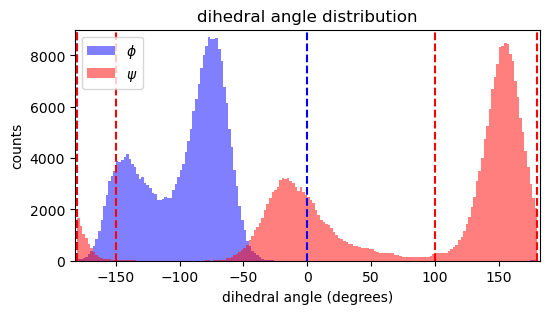

In [4]:
plt.figure(figsize=(6, 3))
plt.hist(phi.results.angles.T[0], bins=180, color='blue', alpha=0.5, label=r"$\phi$")
plt.hist(psi.results.angles.T[0], bins=180, color='red', alpha=0.5, label=r"$\psi$")
plt.xlim(-182,182)
plt.ylim(0, 9000)
plt.xlabel('dihedral angle (degrees)')
plt.ylabel('counts')
plt.title('dihedral angle distribution')
plt.vlines(-180, 0, 9000, colors='blue', linestyles='dashed')
plt.vlines(0, 0, 9000, colors='blue', linestyles='dashed')
plt.vlines(-180, 0, 9000, colors='red', linestyles='dashed')
plt.vlines(-150, 0, 9000, colors='red', linestyles='dashed')
plt.vlines(100, 0, 9000, colors='red', linestyles='dashed')
plt.vlines(180, 0, 9000, colors='red', linestyles='dashed')
plt.legend()
plt.show()

As inidcated above, we use the range [-180,0] for $\phi$ (all frames in our trajectory).
For $\psi$, we select the ranges [-180,-150] or [100,180] which are split by periodic boundary conditions. This is taken into account below. 

Now, we select a consecutive segment of our trajectory which describes fluctuations around a single conformation.

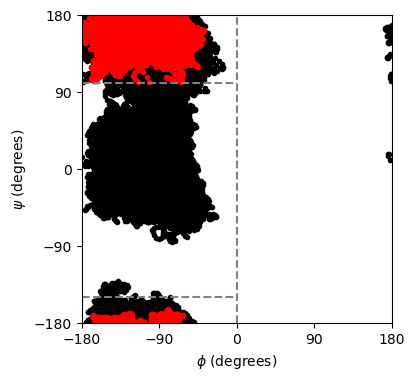

In [5]:
# This algorithm finds the longest consecutive segment of indices in two arrays that satisfy given limits.
# The limits are specified for each array.
# For each array, an alternative limit can be specified as well
# -> this selects array indices that satisfy one of two conditions
def longest_consecutive_indices(array1, lim1, array2, lim2,
                                lim1alt=None,
                                lim2alt=None):
    if lim1alt is None and lim2alt is None:
        mask = (array1 >= lim1[0]) & (array1 <= lim1[1]) \
            & (array2 >= lim2[0]) & (array2 <= lim2[1])
    elif lim1alt is None:
        mask = (array1 >= lim1[0]) & (array1 <= lim1[1]) \
            & (((array2 >= lim2[0]) & (array2 <= lim2[1])) | ((array2 >= lim2alt[0]) & (array2 <= lim2alt[1])))
    elif lim2alt is None:
        mask = (((array1 >= lim1[0]) & (array1 <= lim1[1])) \
                | ((array1 >= lim1alt[0]) & (array1 <= lim1alt[1]))) \
                    & (array2 >= lim2[0]) & (array2 <= lim2[1])
    else:
        mask = (((array1 >= lim1[0]) & (array1 <= lim1[1])) \
                | ((array1 >= lim1alt[0]) & (array1 <= lim1alt[1]))) \
                & (((array2 >= lim2[0]) & (array2 <= lim2[1])) \
                   | ((array2 >= lim2alt[0]) & (array2 <= lim2alt[1])))
    max_len = 0
    max_start = -1
    current_len = 0
    current_start = -1

    for i, val in enumerate(mask):
        if val:
            if current_len == 0:
                current_start = i
            current_len += 1
            if current_len > max_len:
                max_len = current_len
                max_start = current_start
        else:
            current_len = 0

    if max_len == 0:
        return None  # No such segment found
    else:
        return list(range(max_start, max_start + max_len))

# here, we use the algorithm to find the longest consecutive segment in our trajectory that correspondps to the specified conformation    
trajIndices = longest_consecutive_indices(phi.results.angles.T[0], [-180,0], psi.results.angles.T[0], [100,180], lim2alt = [-180,-150])

# here, compare a Ramachandran plot generated from our entire trajectory and the selected segment
plt.figure(figsize=(4, 4))
plt.plot(phi.results.angles.T[0], psi.results.angles.T[0], '.', color='black')
plt.plot(phi.results.angles.T[0][trajIndices], psi.results.angles.T[0][trajIndices], '.', color='red')
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel(r"${\phi}$ (degrees)")
plt.ylabel(r"${\psi}$ (degrees)")
plt.xticks(np.arange(-180, 181, 90))
plt.yticks(np.arange(-180, 181, 90))
plt.vlines(0, -180, 180, colors='gray', linestyles='dashed')
plt.hlines(-150, -180, 0, colors='gray', linestyles='dashed')
plt.hlines(100, -180, 0, colors='gray', linestyles='dashed')
plt.show()

The selected trajectory segment is substantially shorter than our total trajecotry. However, we do not need a lot of data to get reasonably converged results for FRESEAN mode analysis.

In [6]:
# check if the selected segment is long enough for the correlation time
print(f"Selected trajectory segment length: {len(trajIndices) * dt} ps")
print(f"Total trajectory length: {len(u.trajectory) * dt} ps")
if len(trajIndices) < 2 * nCorr:
    print(f"Warning: trajectory segment too short ({len(trajIndices)} frames) for {nCorr} correlation time frames.")
    nCorr = len(trajIndices)/2

Selected trajectory segment length: 66.936 ps
Total trajectory length: 1000.004 ps


Now, we perform a simple RMSD analysis to identify a structure that is most representative of the ensemble of structures selected for our conformation. We then write this structure to a file and use it as our reference structure for FRESEAN mode analysis.

100%|██████████| 670/670 [00:43<00:00, 15.57it/s]


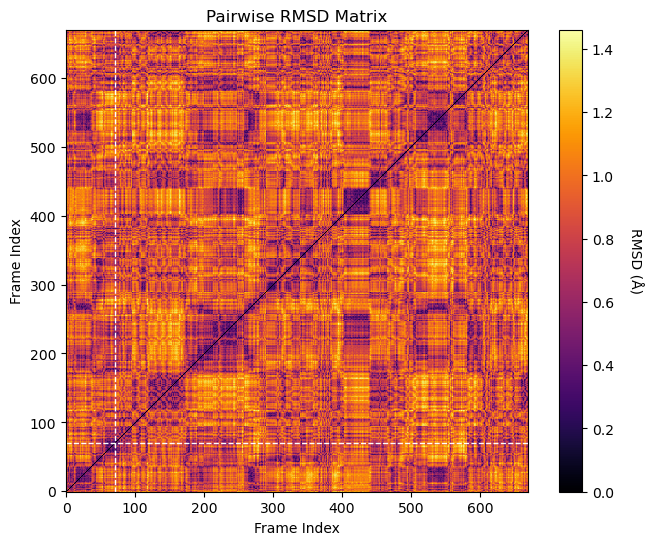

In [7]:
unwrap = pbc.unwrap(u) # make all molecules whole

# we only use every 25th frame for RMSD calculations to speed up the analysis
RMSDtrajFrames = trajIndices[::25]
nRMSD = len(RMSDtrajFrames)

# Compute pairwise RMSD matrix
rmsd_matrix = np.zeros((nRMSD, nRMSD))
for i in tqdm(range(nRMSD)):
    u.trajectory[RMSDtrajFrames[i]]
    unwrap.single_frame()
    A = sel.positions.copy()
    for j in range(i + 1, nRMSD):
        u.trajectory[RMSDtrajFrames[j]]
        unwrap.single_frame()
        B = sel.positions.copy()
        x = rmsd(A, B, center=True, superposition=True)
        rmsd_matrix[i, j] = x
        rmsd_matrix[j, i] = x

# Select the structure with the largest number of structures in the ensemble within the RMSD cutoff
cutoff = 0.75
if np.min(rmsd_matrix) < cutoff:
    row_counts = np.sum(rmsd_matrix < cutoff, axis=1)
    max_count = np.max(row_counts)
    max_row_index = np.where(row_counts == max_count)[0][-1]
max_row_index, np.max(row_counts)

# save the structure that is most representative of the ensemble
with mda.Writer("data/MD-water-300K/conformation-1.xyz", sel.n_atoms) as w:
    u.trajectory[RMSDtrajFrames[max_row_index]]
    unwrap.single_frame()
    align.single_frame()
    w.write(sel)

# update our reference structure for alignment
uRef = mda.Universe('data/MD-water-300K/conformation-1.xyz')
align = fit.align(u, sel, rotVel=1, placeCOMInBox=0, altRefPos=uRef.atoms.positions)

# plot the RMSD matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(rmsd_matrix, cmap='inferno', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('RMSD (Å)', rotation=270, labelpad=20)
plt.title('Pairwise RMSD Matrix')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')
plt.axhline(max_row_index, color='white', linestyle='dashed', linewidth=1)
plt.axvline(max_row_index, color='white', linestyle='dashed', linewidth=1)
plt.gca().invert_yaxis()
plt.show()

### Setup analysis

In [8]:
unwrap = pbc.unwrap(u) # make all molecules whole

# len of trajectory segment needed to allocate arrays
nFrames = len(trajIndices)
# number of atoms in selection
nAtoms = sel.n_atoms
# number of degrees of freedom (DOF) in selection
nDOF = nAtoms * 3 - nConstraints
# allocate arrays to store atomic velocities
velocities = np.zeros((nAtoms * 3, nFrames), dtype=np.complex128)
# store square root of atomic masses for each DOF
sqm = np.repeat(np.sqrt(sel.atoms.masses), 3)

# define Gaussian window for FFT
# - frequency resolution in cm**-1
wn0 = 1.0 / ((2 * nCorr -1) * dt) * 33.3564
# - frequency range for spectra
freqs = np.arange(nCorr) * wn0
# normalization factor for Gaussian window function in frequency domain
winNorm = 1.0 / np.sqrt(2.0 * np.pi * sigma**2)
# - array to store Gaussian window (in time and frequency domain)
winFreq = np.zeros(2 * nCorr - 1)
winTime = np.zeros(2 * nCorr - 1)
# create Gaussian window in frequency domain
# - first half is Gaussian, second half is a mirror image
# - this is to ensure that the window is real-valued in the time domain
winFreq[0:nCorr] = winNorm * np.exp(-0.5 * freqs**2 / sigma**2)
winFreq[nCorr:] = winFreq[nCorr-1:0:-1]
# generate the Gaussian window in time domain
winTime = np.real(ifft(winFreq))

# allocate the velocity correlation matrix
corrMatrix = np.empty((nCorr, nAtoms * 3, nAtoms * 3))

### Loop over trajectory

- unwrap periodic boundary conditions if needed
- perform translational/rotational alignment (rotate velocities)
- store $\sqrt{m} \cdot \tilde{\mathrm{v}}(t)$ for all atoms in selection

In [9]:
for i, ts in enumerate(tqdm(u.trajectory[trajIndices])):
    unwrap.single_frame()
    align.single_frame()
    velocities[:, i] = sqm * sel.velocities.flatten()

100%|██████████| 16734/16734 [00:03<00:00, 4597.03it/s]


## **FREquency-SElective ANharmonic (FRESEAN) mode analysis: Part 1**

### **Computing the velocity correlation matrix $\mathbf{C}_{\tilde{\mathrm{v}}}$**

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

In [10]:
# Fourier transform of velocities (Eq. 2)
velocities = fft(velocities, axis=1)

# arrays for temporary data storage
tmp1 = np.zeros(nFrames, dtype=np.float64)
tmp2 = np.zeros(nFrames, dtype=np.float64)
tmp3 = np.zeros(2 * nCorr -1, dtype=np.float64)
# loop over all correlation matrix elements
for i in tqdm(range(nAtoms * 3)):
    for j in range(i, nAtoms * 3):
        # one element of correlation matrix
        # multiply Fourier transformed velocities (Eq. 3)
        # and enforce real-valued result (Eq. 4)
        tmp1 = np.real(velocities[i] * velocities[j].conj())
        # transform from frequency into time domain (Eq. 5)
        tmp2 = np.real(ifft(tmp1))
        # cut off time domain data after tau_max = nCorr * dt
        tmp3[:nCorr] = tmp2[:nCorr]
        # enforce time symmetry of truncated time correlation function
        tmp3[nCorr:] = tmp2[nCorr-1:0:-1]
        # multiply with Gaussian window function in time domain (Eq. 8)
        tmp3 *= winTime
        # and Fourier transform into frequency domain (Eq. 8)
        corrMatrix[:,i, j] = np.real(fft(tmp3)[:nCorr])
        if i != j:
            # use symmetry of correlation matrix
            corrMatrix[:, j, i] = corrMatrix[:, i, j]
# correct for implicit multiplication in power spectrum
corrMatrix /= nFrames
# free memory used to store velocities and temporary data
del velocities, tmp1, tmp2, tmp3

100%|██████████| 66/66 [00:01<00:00, 33.82it/s]


## **FRESEAN mode analysis: Part 2**

### **Computing eigenvectors an eigenvalues**

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details


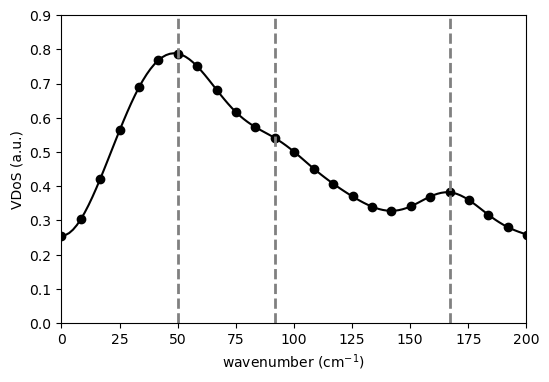

In [11]:
eigenvalues = []
eigenvectors = []
for i in range(nCorr):
    vals, vecs = np.linalg.eigh(corrMatrix[i])
    # sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(vals)[::-1] # indices for descending order
    vals = vals[idx]
    vecs = vecs[:, idx]
    eigenvalues.append(vals)
    # Note: access i'th eigenvector as vecs.T[i]
    eigenvectors.append(vecs.T) # transpose to have eigenvectors as rows
# convert lists to numpy arrays
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

# here we compute the average temperature of the system
# we consider some of the idiosyncracies of symmetrized and discretized data
avgTemp = (np.sum(eigenvalues[0]) + 2 * np.sum(eigenvalues[1:])) / (2 * nCorr - 1) / winTime[0] / (8.3145 * 0.1) / nDOF
# this normalization factor for eigenvalues and the corrMatrix ensures that simple sums over VDoS (ignoring symmetry) roughly the corresponding number of DOF
VDoSnorm = nCorr * winTime[0] * (8.3145 * 0.1 * avgTemp)

# normalize eigenvalues and corrMatrix
eigenvalues /= VDoSnorm
corrMatrix /= VDoSnorm

# total VDoS (Eq. 10 avove)
VDoStot = np.sum(eigenvalues, axis=1)
# find peaks in total VDoS
peakIndices = np.where((VDoStot[1:-1] > VDoStot[:-2]) & (VDoStot[1:-1] > VDoStot[2:]))[0] + 1
peakIndices = np.sort(np.array([11] + peakIndices.tolist()))
# peak frequencies
peakFreqs = freqs[peakIndices]

# total vibrational density of states below 200 wavenumbers
g.plotSpectra(freqs, 
            VDoStot, 
            xlim=[0,200], 
            ylim=[0,0.9], 
            vlines = freqs[peakIndices].tolist(),
            filename='figures/MD-water-300K_totalVDoS.png')

The total vibrational density of states changed quite a bit compared to the gas phase. Specifically, we see a strong imprint of the vibrational spectrum of the solvent, i.e., vibrations of the water hydrogen bond network. 
The water VDoS features a prominent peak around 50 $\mathrm{cm}^{-1}$ (slightly depends on the water model), which drastically enhances a corresponding peak in our solute at the same frequency. We recall that this peak was only a shoulder in the gas phase VDoS at 300K.

Only one other peak is observed between 150 and 175 $\mathrm{cm}^{-1}$, which we also observed in the gas phase. However, a gas phase peak around 80 $\mathrm{cm}^{-1}$ is now just a broad shoulder of the low frequency peak. We manually add its frequency to our list of peak frequencies for the following analysis. However,first, we will begin with an analysis of the VDoS at zero frequency.

### **Analyzing VDoS contributions at zero frequency**

Because the translations and rotations of the molecule are not constrained in this simulation, the zero-frequency VDoS contains information of the translational and rotational diffusion of the solute. 

In addition, the zero-frequency VDoS contains contributions from damped low-frequency vibrations. These vibrations are of particular interest, because they tend to describe low-frequency vibrations that change the conformation of the molecule. One can speculate that this is the cause of their damping. In previous work, we have used these vibrations successfully as collective variables in enhanced sampling simulations (S. Mondal, M. A. Sauer, M. Heyden, *J. Phys. Chem. B* **2024**, 128, 7112-7120.)

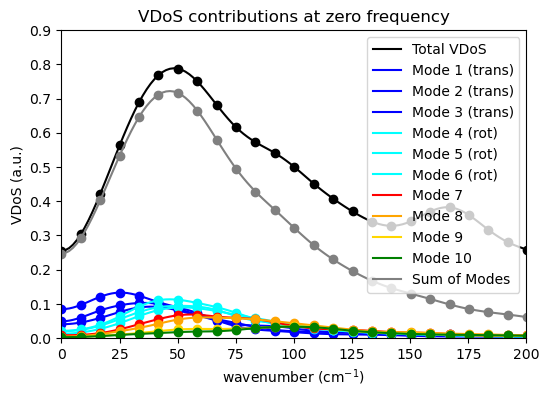

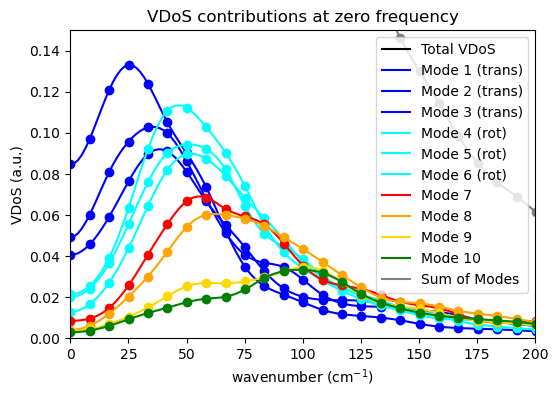

In [12]:
# we will analyze the first 10 modes contributing to the VDoS at zero-frequency
# these include 3 translations, 3 rotations and 4 damped low-frequency vibrations
nModes = 10
# Selected eigenvectors (vibrational modes) with largest VDoS contribution at zero frequency
zeroFreqVibModes = eigenvectors[0,0:nModes]
# 1D-VDoS of modes contributing at zero frequency
# (see Eq. 11)
zeroFreqModesVDoS = np.zeros((nModes, nCorr))
for m in range(nModes):
    for i in range(nCorr):
        zeroFreqModesVDoS[m, i] = np.dot(zeroFreqVibModes[m], np.dot(corrMatrix[i], zeroFreqVibModes[m]))

# plot 1D-VDoS of vibrational modes contributing at zero frequency
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in zeroFreqModesVDoS] + [np.sum(zeroFreqModesVDoS, axis=0)],
            xlim=[0,200], 
            ylim=[0,0.9], 
            colors=['black', 'blue', 'blue', 'blue', 'cyan', 'cyan', 'cyan', 'red', 'orange', 'gold', 'green', 'gray'],
            labels=['Total VDoS', 'Mode 1 (trans)', 'Mode 2 (trans)', 'Mode 3 (trans)', 'Mode 4 (rot)', 'Mode 5 (rot)', 'Mode 6 (rot)', 'Mode 7', 'Mode 8', 'Mode 9', 'Mode 10', 'Sum of Modes'],
            filename='figures/MD-water-300K_zero-frequency-VDoS.png',
            title = "VDoS contributions at zero frequency")

g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in zeroFreqModesVDoS] + [np.sum(zeroFreqModesVDoS, axis=0)],
            xlim=[0,200], 
            ylim=[0,0.15], 
            colors=['black', 'blue', 'blue', 'blue', 'cyan', 'cyan', 'cyan', 'red', 'orange', 'gold', 'green', 'gray'],
            labels=['Total VDoS', 'Mode 1 (trans)', 'Mode 2 (trans)', 'Mode 3 (trans)', 'Mode 4 (rot)', 'Mode 5 (rot)', 'Mode 6 (rot)', 'Mode 7', 'Mode 8', 'Mode 9', 'Mode 10', 'Sum of Modes'],
            filename='figures/MD-water-300K_zero-frequency-VDoS.png',
            title = "VDoS contributions at zero frequency")

Notably, the 1D-VDoS for the first 6 modes, which indeed describe translations and rotations (you can visualize them at the end of this notebook), feature a peak at non-zero frequencies. The alanine dipetide is vibrating or "rattling" in its solvation cage, e.g., the hydrogen bond network of its hydration shell. This is typical for small molecules. For large molecules such as proteins, the 1D-VDoS for translational and rotational motions (modes 1-6 at zero frequency) have a peak at zero frequency.

Given our observations, it is clear that the translational and rotational modes of the solute provide dominant contributions to the 50 $\mathrm{cm}^{-1}$ in the total VDoS.

The 1D-VDoS of zero frequency modes 7-10 have peaks in the range of 50-100 $\mathrm{cm}^{-1}$. They contribute to the zero-frequency VDoS due the presence of significant low-frequency tails in their spectrum. These can be indiciative of a highly anharmonic effective potential and/or damping (by the solvent).

Upon visualization of these modes (see end of the notebook), we observe modes 7 and 8 describe rotations of the peptide bond dihedrals, which reproduces our observation in previous work (S. Mondal, M. A. Sauer, M. Heyden, *J. Phys. Chem. B* **2024**, 128, 7112-7120.). 

This directly supports the use of these vibrations as collective variables in enhanced sampling simulations. Importantly though, FRESEAN mode analysis at zero frequency allows us to identify these degrees of freedom without the need of prior knowledge of the system. We only need to analyze fluctuations within a stable conformation. 
Here, we used the dihedral angles to identify such a sonformation. However, any other method such as RMSD clustering of a trajectory could be used as well.

### **Analyzing contributions to selected peaks in the total VDoS**

FRESEAN mode analysis allows us to identify the vibrational modes contributing to the total VDoS at any sampled frequency. In the following, we will analyze contributions from the 7 most important vibrations that contribute to the low-frequency peaks of the total VDoS.

Note the increase in the number of modes to be analyzed at each frequency compared to gas phase simulations (where we used only 4 modes per frequency).

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

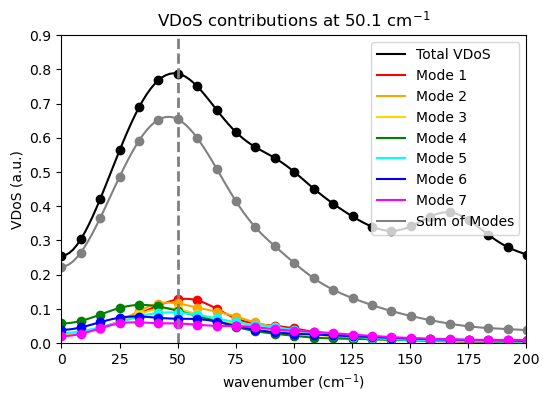

In [13]:
# select low-frequency peaks below 200 wavenumbers
lowFreqPeakIndices = peakIndices[np.where(peakFreqs < 200)[0]]
nLowFreqPeaks = len(lowFreqPeakIndices)
# select number of most important modes to be extracted for each low-frequency peak
nModes = 7
# Selected eigenvectors (vibrational modes) with largest VDoS contribution at each low-frequency peak
lowFreqVibModes = eigenvectors[lowFreqPeakIndices,0:nModes]
# 1D-VDoS for four most contributing vibrational modes at each low-frequency peak
# (see Eq. 11)
lowFreqModesVDoS = np.zeros((nLowFreqPeaks, nModes, nCorr))
for p in range(nLowFreqPeaks):
    for m in range(nModes):
        for i in range(nCorr):
            lowFreqModesVDoS[p, m, i] = np.dot(lowFreqVibModes[p, m], np.dot(corrMatrix[i], lowFreqVibModes[p, m]))

# plot 1D-VDoS of vibrational modes contributing most at selected low-frequency peak
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in lowFreqModesVDoS[lowFreqPeakIndex]] + [np.sum(lowFreqModesVDoS[lowFreqPeakIndex], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.9], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7','Sum of Modes'],
            filename='figures/MD-water-300K_peak-' + f"{lowFreqPeakIndex+1}" + '-modes-VDoS.png',
            vlines = freqs[lowFreqPeakIndices[lowFreqPeakIndex]],
            title = "VDoS contributions at " + f"{freqs[lowFreqPeakIndices[lowFreqPeakIndex]]:.1f}" + " cm$^{-1}$")

Feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the main contributions to the other low-frequency peaks in the VDoS. 

It is apparent that the VDoS intensity at a given frequency is now more evenly distributed over a larger set of vibrational modes compared to the gas phase. The 1D-VDoS of each vibrational mode features much broader peaks in solution, which thus contribute to many distinct frequencies. 

Vibrations at at the first peak frequency of 50 $\mathrm{cm}^{-1}$ have lrge contributions from the rotational and translational modes of the solute "rattling" in its solvation cage. We can easily show that by computing the correlations to the first 6 modes at zero frequency.

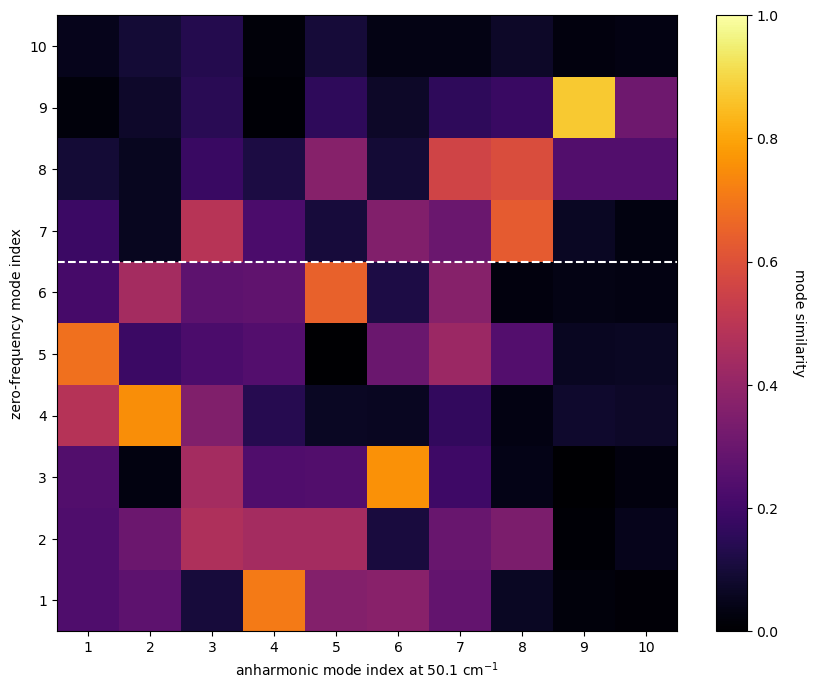

In [14]:
# compute comparison matrix between clustered vibrational modes
compareMatrix = np.zeros((10,10), dtype = np.float64)
freq1 = lowFreqPeakIndices[0]
for i in range(10):
    for j in range(10):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectors[0][i],eigenvectors[freq1][j]))

# plot the comparison matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('anharmonic mode index at ' + f"{freqs[freq1]:.1f}" + ' cm$^{-1}$')
plt.ylabel('zero-frequency mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(10), labels=np.arange(1, 10 + 1))
plt.yticks(ticks=np.arange(10), labels=np.arange(1, 10 + 1))
plt.hlines(5.5,-0.5,9.5, colors='white', linestyles='dashed')
plt.savefig('figures/MD-water-300K_anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

Clearly, the first 8 modes at 50 $\mathrm{cm}^{-1}$ have substantial overlap with zero-frequency modes 1-6, i.e., the translational and rotational modes.

The number of non-zero eigenvalues gives us another way to judge how many vibrational modes are contributing to the VDoS at each frequency. Below, we plot the first 10 eigenvalues for zero frequency and each low-frequency peak in the total VDoS.

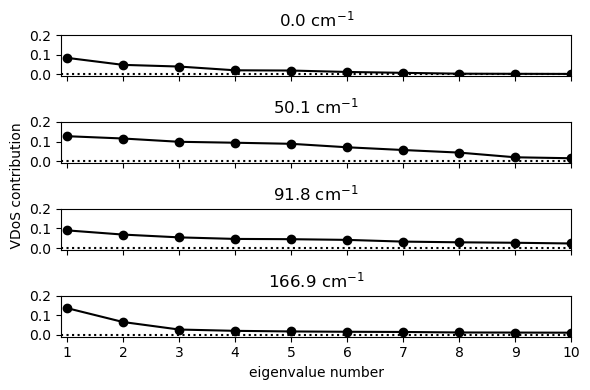

In [15]:
fig, axs = plt.subplots(nLowFreqPeaks + 1, 1, figsize=(6,nLowFreqPeaks * 4/3), sharex=True)

freqIndices = np.array([0] + lowFreqPeakIndices.tolist())

for idx, ax in enumerate(axs):
    ax.plot(range(1, 10 + 1), eigenvalues[freqIndices[idx]][0:10], color='black')
    ax.plot(range(1, 10 + 1), eigenvalues[freqIndices[idx]][0:10], 'o', color='black')
    ax.set_xlim(0.9, 10)
    ax.set_ylim(-0.01, 0.15)
    ax.set_title(f"{freqs[freqIndices[idx]]:.1f} cm$^{{-1}}$")
    hlines = ax.axhline(0, color='black', linestyle=':')
    ax.set_yticks(ticks=np.arange(0.0,0.3,1/10), labels=[f"{x:.1f}" for x in np.arange(0.0,0.3,1/10)])
plt.xticks(ticks=range(1, 10 + 1), labels=range(1, 10 + 1))
axs[-1].set_xlabel("eigenvalue number")
axs[2].set_ylabel("                    VDoS contribution")
plt.tight_layout()
plt.savefig('figures/MD-water-300K_lowFreqPeaks-eigenvalues.png', dpi=300)
plt.show()

Compared to the gas phase simulations at both 50K and 300K, we can clearly see that the number of non-zero eigenvalues for a given frequency has increased. For frequencies above 0.0 $\mathrm{cm}^{-1}$, even the 10'th eigenvalue is not yet exactly zero.

We can use Eq. 11 to compute correlation functions between any two distinct degrees of freedom in the frequency domain. We then symmetrize and perform an inverse Fourier transform to get the corresponding time auto and cross corerlation functions.

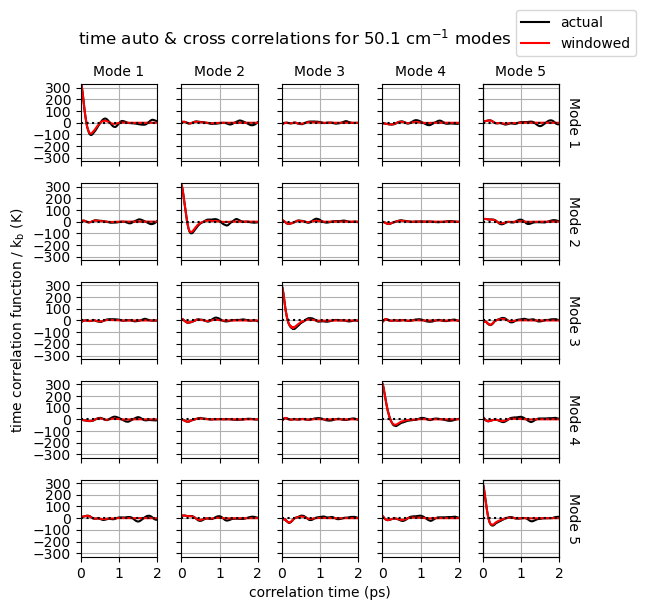

In [16]:
# select low frequency peak for time correlation analysis
# Note: we are not limited to analyzing correlations between vibrational modes at the same frequency
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
idx = lowFreqPeakIndices[lowFreqPeakIndex]
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(5, 5, figsize=(6,6), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectors[idx, i], np.dot(corrMatrix[k], eigenvectors[idx, j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # convert to mode temperature
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * nCorr
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][2].set_xlabel("correlation time (ps)")
axs[2][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for {freqs[idx]:.1f} cm$^{{-1}}$ modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,4]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.08, 1.02))
plt.savefig('figures/MD-water-300K_peak-' + f"{lowFreqPeakIndex+1}" + '-5x5-time-correlations.png', dpi=300)
plt.show()

Again, feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the correlations between vibrational modes contributing to the VDoS at the other low-frequency peaks.

Note that cross correlations between vibrational modes have substantially decreased compared to the gas-phase at 300K. Instead of energy transfer between distinct vibrational modes of the solute, we now primarily observe energy transfer into the solvent!

### **Finding key anharmonic vibrations**

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

If we aim to focus on actual internal vibrations of alanine dipeptide, e.g., to compare to harmonic normal modes 7-13, we need to eliminate contributions from translations and rotations in our matrix. 

To do that, we subtract their projections below before we calculate our correlation matrix.

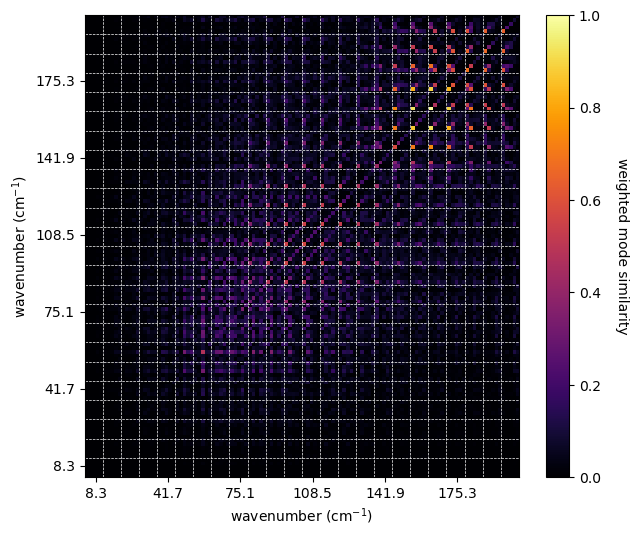

In [17]:
# select eigenvectors and eigenvalues for frequencies below 200 cm$^{-1}$
freqSelIndices = np.where((freqs > 0) & (freqs < 201))[0]
eigenvectorsSel = []
eigenvaluesSel = []
for i in freqSelIndices:
    for m in range(5):
        eigenvaluesSel.append(eigenvalues[i, m])
        eigenvectorsSel.append(eigenvectors[i, m])
eigenvectorsSel = np.array(eigenvectorsSel)
eigenvaluesSel = np.array(eigenvaluesSel)
maxEigenvalue = np.max(eigenvaluesSel)
nSel = len(eigenvaluesSel)

# construct a weighted comparison matrix (see Eq. 12)
clusterMatrix = np.zeros((nSel, nSel), dtype=np.float64)
for i in range(nSel):
    if eigenvaluesSel[i] > 0:
        a = np.sqrt(eigenvaluesSel[i])
    else:
        a = 0.0
    # subtract any overlap with the translations and rotations for one eigenvector
    vec1 = eigenvectorsSel[i].copy()
    for k in range(6):
        proj = np.dot(vec1, eigenvectors[0][k])
        vec1 -= proj * eigenvectors[0][k]
    for j in range(nSel):
        if eigenvaluesSel[j] > 0:
            b = np.sqrt(eigenvaluesSel[j])
        else:
            b = 0.0
        # subtract any overlap with the translations and rotations for the second eigenvector
        vec2 = eigenvectorsSel[j].copy()
        for k in range(6):
            proj = np.dot(vec2, eigenvectors[0][k])
            vec2 -= proj * eigenvectors[0][k]
        clusterMatrix[i, j] = a*b/maxEigenvalue*np.abs(np.dot(vec1, vec2))

# plot the weighted comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(clusterMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
cbar = plt.colorbar(im)
cbar.set_label('weighted mode similarity', rotation=270, labelpad=20)
plt.xlabel('wavenumber (cm$^{-1}$)')
plt.ylabel('wavenumber (cm$^{-1}$)')
for l in range(5,125,5):
    plt.axhline(l-0.5, color='white', linestyle='--', linewidth=0.5)
    plt.axvline(l-0.5, color='white', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.yticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.savefig('figures/MD-water-300K_clustering-matrix.png', dpi=300)
plt.show()

This clustering matrix contains information on how many unique vibrational modes we detected in the low-frequency range for our selection. 

Of course, we need to remember that we forcibly eliminated vibrational modes with any similarity to translations and rotations.

#### Clustering of low-frequency vibrations

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

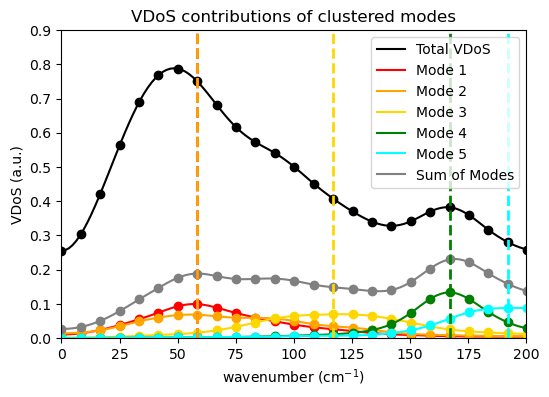

In [18]:
cutoff = 0.3
clusterIndices = []
matrix = clusterMatrix.copy()
if np.max(matrix) > cutoff:
    while True:
        # counts the number of elements in each row that are larger than the cutoff
        row_counts = np.sum(matrix > cutoff, axis=1)
        max_count = np.max(row_counts)
        # if no row has elements larger than the cutoff, break the loop
        if max_count == 0:
            break
        # find the row with the larger number of elements larger than the cutoff
        # this index corresponds to the center of a cluster of similar modes
        # (Note: I avoid the use of np.argmax() here to emulate the exact behavior of a previous implementation of this algorithm in Mathematica)
        max_row_index = np.where(row_counts == max_count)[0][-1]
        # add index to the list of clusters
        clusterIndices.append(max_row_index)
        # find indices of all the elements in the selected row that are larger than the cutoff
        # these are the cluster members and need to be removed from the matrix
        indices_to_remove = np.where(matrix[max_row_index] > cutoff)[0]
        # for all members of current cluster, remove rows and columns from the matrix (set entries to 0)
        matrix[:, indices_to_remove] = 0
        matrix[indices_to_remove, :] = 0
# select the eigenvectors and eigenvalues for the cluster centers
clusterIndices = np.array(clusterIndices)
nClusterModes = len(clusterIndices)
eigenvectorsCluster = eigenvectorsSel[clusterIndices]
eigenvaluesCluster = eigenvaluesSel[clusterIndices]

# compute the 1D-VDoS for the clustered vibrational modes (Eq. 11)
VDoSclusterModes = np.zeros((nClusterModes, 25))
for m in range(nClusterModes):
    for i in range(25):
        VDoSclusterModes[m, i] = np.dot(eigenvectorsCluster[m], np.dot(corrMatrix[i], eigenvectorsCluster[m]))

# find the peaks in the 1D-VDoS of clustered vibrational modes
# sort the clustered eigenvectors, eigenvalues, and their 1D-VDoS according to their peak frequency
peak_indices_cluster_modes = np.argmax(VDoSclusterModes, axis=1)
sort_indices = np.argsort(peak_indices_cluster_modes)
peak_indices_cluster_modes = peak_indices_cluster_modes[sort_indices]
clusterIndices = clusterIndices[sort_indices]
eigenvectorsCluster = eigenvectorsCluster[sort_indices]
eigenvaluesCluster = eigenvaluesCluster[sort_indices]
VDoSclusterModes = VDoSclusterModes[sort_indices]

# plot 1D-VDoS of clustered vibrational modes
# to keep things consistent, we plot the 1D-VDoS for the first 7 clustered modes (largest clusters)
g.plotSpectra(freqs[0:25],
            [VDoStot[0:25]] + [arr for arr in VDoSclusterModes[0:5]] + [np.sum(VDoSclusterModes[0:5], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.9], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Sum of Modes'],
            filename='figures/MD-water-300K_anharmonic-modes-VDoS.png',
            vlines = freqs[peak_indices_cluster_modes[0:5]].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan'],
            title = "VDoS contributions of clustered modes")

The clustering (using the same cutoff as for the gas phsase simulations) identified only 5 key vibrations contributing to the low-frequency spectrum of alanine dipeptide in solution. 

It is not surpising that the sum of the corresponding 5 1D-VDoS only describes a small fraction of the total VDoS at 50 $\mathrm{cm}^{-1}$ and below, because these vibrations are dominated by translations and rotations which were excluded. 

However, also the peak at approximately 175 $\mathrm{cm}^{-1}$ is only partially described by the sum of the 5 identified modes. Essentially, we find that the number of modes contributing to the VDoS at any given frequency is large (as we have already seen from the eigenvalues above). 
While our clustering analysis identified the most important modes in the low frequency spectrum, many more vibrational modes are needed to explain the entire VDoS.

#### Comparing anharmonic vibrational modes

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

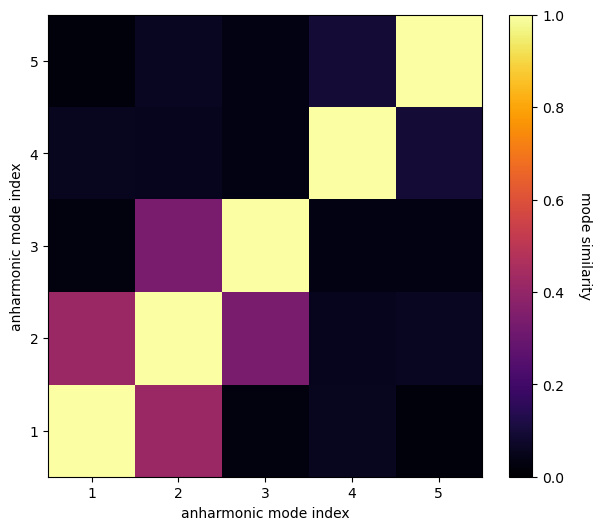

In [19]:
# compute comparison matrix between clustered vibrational modes
compareMatrix = np.zeros((nClusterModes,nClusterModes), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(nClusterModes):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],eigenvectorsCluster[j]))

# plot the comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('anharmonic mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.yticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.savefig('figures/MD-water-300K_anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

Only eigenvectors obtained from $\mathbf{C}_{\tilde{v}}(\omega)$ at the same frequency are guaranteed to tbe orthogonal. Our clustering algorithm selected eigenvectors obtained from different frequencies, which are thus not guaranteed to be orthogonal.

Already for the gas phase at room temperature, we saw that the clustered vibrational modes had some overlap and could have been merged further into super clusters. In solution, we now see that significant vibrations (that are not translations or rotations) have indeed reduced to 5 vibrational modes, which are more or less unique. Only mode 2 has minor overlap with both modes 1 and 3.

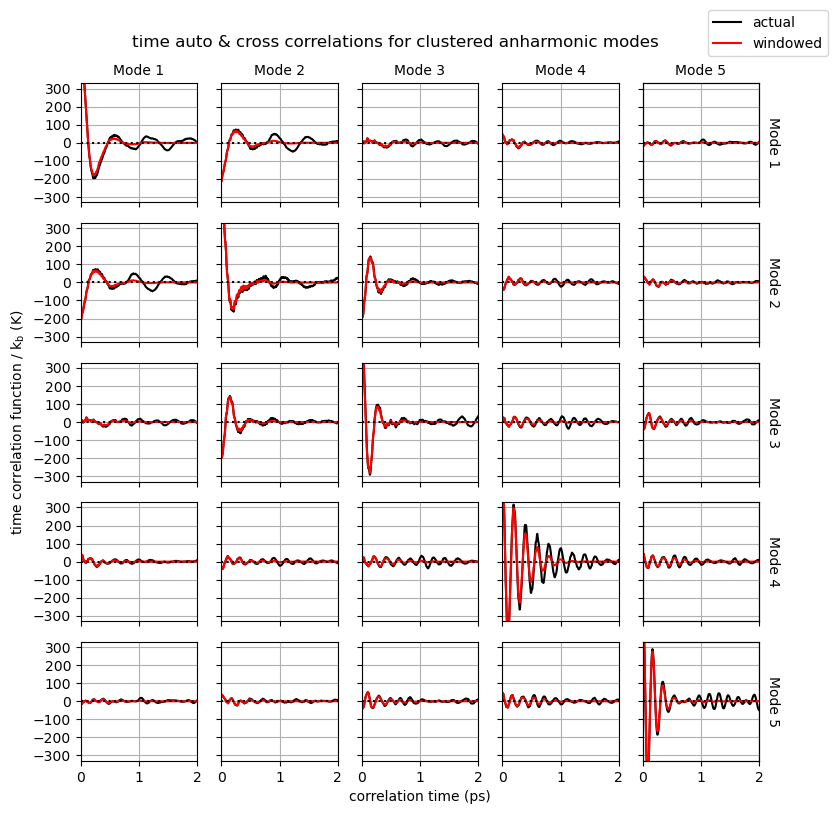

In [20]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(5, 5, figsize=(8,8), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectorsCluster[i], np.dot(corrMatrix[k], eigenvectorsCluster[j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # remove scaling from window function, divide by kB, convert units and correct for symmetry
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * (2 * nCorr -1)
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][2].set_xlabel("correlation time (ps)")
axs[2][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for clustered anharmonic modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,4]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-water-300K_anharmonic-modes-5x5-time-correlations.png', dpi=300)
plt.show()

The largest cross correlation are found between modes 1 & 2 and modes 2 & 3, which have non-zero overlap and thus imply some correlations at correlation times tau = 0. Otherwise, cross correlationsare are minor. 

In the auto correlation for mode 5, we observe a fast decay followed by an increase in the amplitude of oscillations. The latter is quenched by the window function used in our analysis, but the oscillation with a period of approximately 1 picosecond matches the frequency of translational rattling vibrations of alanine dipeptide in its hydration shell.

### Comparison to harmonic normal modes

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

We computed $\mathbf{C}_{\tilde{v}}(\omega)$ using a reference structure representing a conformational ensemble in the simulation, not the minimum energy structure used to compute the harmonic normal modes. 

However, we aligned this reference structure with the structure at the potential energy minimum, which ensures that both are in the same frame of reference. Indeed, recomputing $\mathbf{C}_{\tilde{v}}(\omega)$ with the minimum energy structure as a reference does not provide improve the following results.

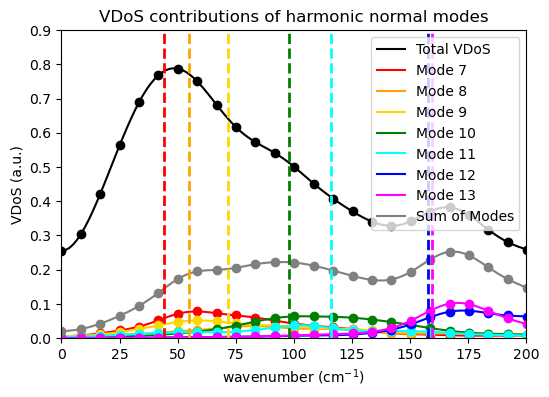

In [21]:
# generating data sets for plots
# importing harmonic normal modes for comparison
harmonic = mda.Universe("data/harmonic-normal-modes/eigenvec.xyz","data/harmonic-normal-modes/eigenvec.xyz")
harmonicModes = np.zeros((3 * nAtoms, 3 * nAtoms), dtype=np.float64)
for m in range(3 * nAtoms):
    harmonicModes[m] = harmonic.trajectory[m].positions.flatten()
# 1D-VDoS for all harmonic normal modes
# computed with Eq. 11 above
VDoSharmonicModes = np.zeros((3 * nAtoms, nCorr))
for m in range(3 * nAtoms):
    for i in range(nCorr):
        VDoSharmonicModes[m, i] = np.dot(harmonicModes[m], np.dot(corrMatrix[i], harmonicModes[m]))
# Import harmonic frequencies
harmonicFreqs = np.loadtxt('data/harmonic-normal-modes/eigenfreq.dat', comments='#')[:,1]

# plot 1D-VDoS of harmonic normal modes 7-12 (omit modes 1-6, which describe tranlations/rotations)
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in VDoSharmonicModes[6:13]] + [np.sum(VDoSharmonicModes[6:13], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.9], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 7', 'Mode 8', 'Mode 9', 'Mode 10', 'Mode 11', 'Mode 12', 'Mode 13', 'Sum of Modes'],
            # filename='figures/MD-water-300K_harmonic-modes-VDoS.png',
            vlines = harmonicFreqs[6:13].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta'],
            title = "VDoS contributions of harmonic normal modes")

For all harmonic modes, we observe very broad peaks with peak intensities that are even lower than in the 1D-VDoS of vibrational modes obtained after clustering results from FRESEAN mode analysis. Only mode 12 exhibits a reasonably well-defined peak, whose intensity is nevertheless about 50% lower than the peak intensity of the corresponding anharmonic mode 4 obtained through clustering (see above). 

While broadened peaks are expected in solution, due to fluctuations in the solvation environment and damping, the harmonic normal modes do not provide the best basis to describe the vibrations of solvated alanine dipeptide.

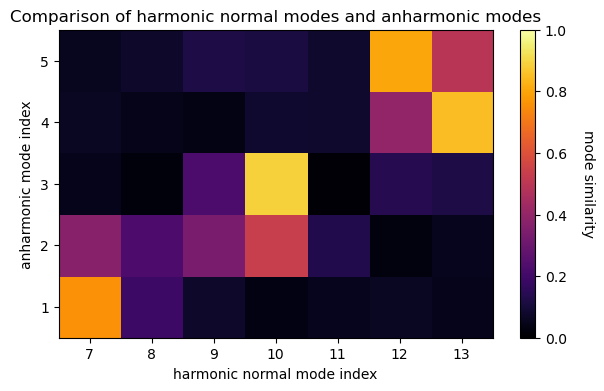

In [22]:
# compute comparison matrix between clustered vibrational modes and harmonic normal Modes
compareMatrix = np.zeros((nClusterModes,7), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(7):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],harmonicModes[j+6]))

# plot the comparison matrix
plt.figure(figsize=(7, 4))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('harmonic normal mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(7), labels=np.arange(1, 7 + 1) + 6)
plt.yticks(ticks=np.arange(5), labels=np.arange(1, 5 + 1))
plt.title('Comparison of harmonic normal modes and anharmonic modes')
plt.savefig('figures/MD-water-300K_harmonic-anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

Interestingly, there is some overlap between the harmonic normal modes and the clustered anharmonic modes. 

Out of the 7 low frequency harmonic normal modes (modes 7-13), we can see that mode 11 has been eliminated from the spectrum while modes 8 and 9 are significantly quenched. The corresponding DOF still exists of course, but the corresponding 1D-VDoS has such a broad spectrum that this motion does not correspond to any specific frequency. 

Upon visualizing the harmonic normal modes (see end of the notebook), we see that mode 11, as well as modes 8 and 9, primarily describe methyl group rotations.

The other harmonic normal modes have survived, at least in spirit, and contribute peaks to the total VDoS. However, as noted above, when we compare their peak intensities with the 1D-VDoS of the clustered anharmonic modes, it does become clear that the latter provide a more accurate description of solute vibrations in solution.

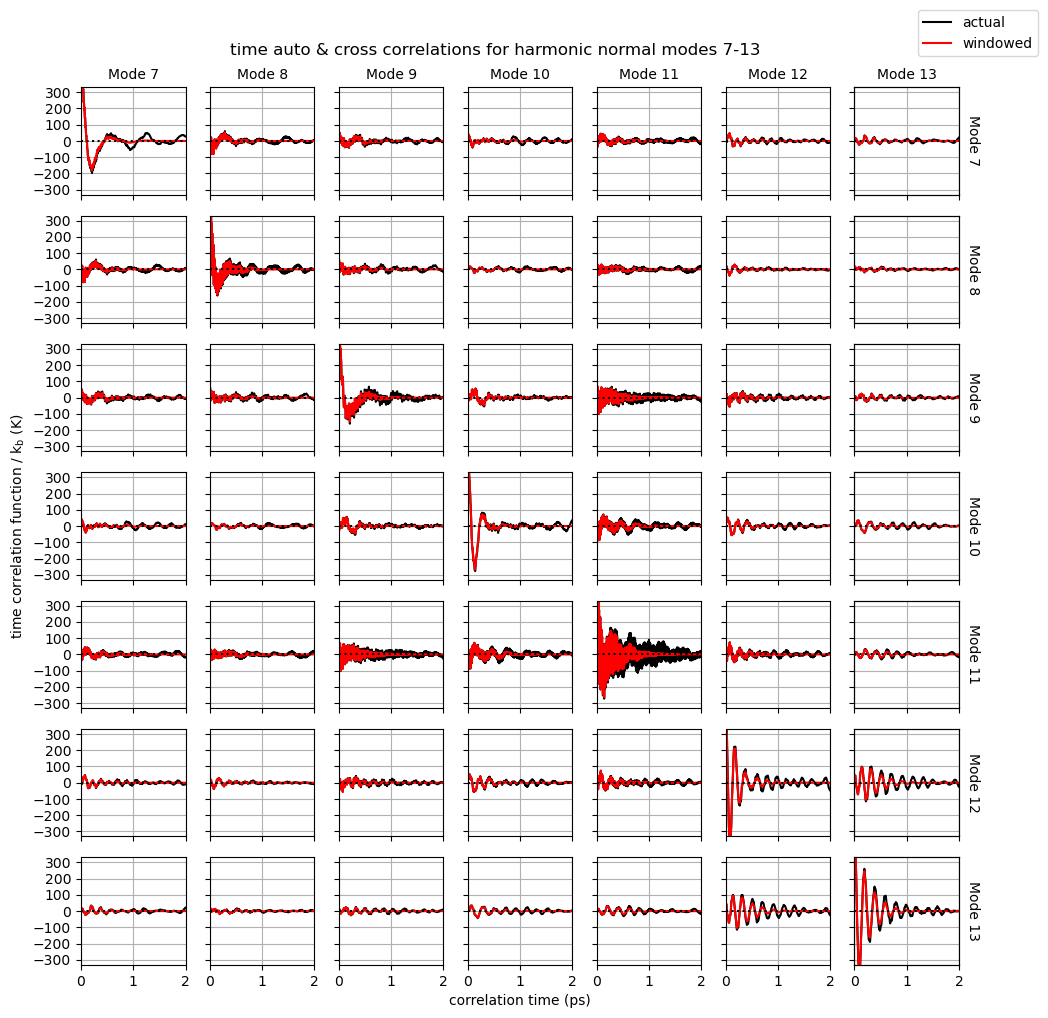

In [23]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(7, 7, figsize=(10,10), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(harmonicModes[i+6], np.dot(corrMatrix[k], harmonicModes[j+6]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # remove scaling from window function, divide by kB, convert units and correct for symmetry
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * (2 * nCorr -1)
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][3].set_xlabel("correlation time (ps)")
axs[3][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for harmonic normal modes 7-13")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+7}", fontsize=10)
for i, ax in enumerate(axs[:,6]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+7}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-water-300K_harmonic-modes-7x7-time-correlations.png', dpi=300)
plt.show()

The auto correlations for modes 11, and to a lesser degree for modes 8 and 9, show that these motions can not be clearly associated with a single frequency. 
For the other harmonic normal modes, we observe relatively clean auto-correlations. However, contributions from multiple frequencies can be observed as "noise" on top of the time domain oscillations.

For the anharmonic vibrations extracted from FRESEAN mode analysis, this noise level is lower which translates into sharper peaks in the corresponding 1D-VDoS.

## **Vibrational Mode Visualization**

In the following, we can visualize vibrational modes. Importantly, the eigenvectors of either $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ or the mass-weighted Hessian matrix require scaling prior to visualization. 

This is usually done automatically by most programs that visualize vibrational modes. The easiest way to show this is by computing the dot products between the eigenvectors of a given matrix. If the vectors are not orthonormal, they have been modified.

To convert eigenvector components into displacements suitable for visualization, we scale them with $1/\sqrt{m}$, where $m$ is the mass of the corresponding atom.

We begin by (re-)loading our reference structure, which we will use to visualize the atomic displacement vectors described by the eigenvectors of $\mathbf{C}_{\tilde{v}}(\omega)$ or the harmonic normal modes.

In [24]:
uVis = mda.Universe("data/MD-water-300K/topol.tpr","data/MD-water-300K/conformation-1.xyz")
selVis = uVis.select_atoms("all")

In [25]:
# anharmonic mode visualization (any eigenvectors at any frequency can be visualized)
# frequency index (any value between 1 and nCorr)
frequencyIndex = 7
# mode index (any value between 1 and 66 = 3 * nAtoms)
modeNumber = 1
print(f"Selected eigenvector {modeNumber} at frequency {freqs[frequencyIndex-1]:.1f} cm$^{-1}$")
disp = np.reshape(eigenvectors[frequencyIndex-1, modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected eigenvector 1 at frequency 50.1 cm$^-1$


Widget(value='<iframe src="http://localhost:54174/index.html?ui=P_0x1bce22a20_0&reconnect=auto" class="pyvista…

In [26]:
# clustered anharmonic mode visualization (select one of the cluster centers)
# mode index (any value between 1 and 7)
modeNumber = 1
print(f"Selected clustered anharmonic mode {modeNumber} with peak at frequency {freqs[peak_indices_cluster_modes[modeNumber-1]]:.1f} cm$^{-1}$")
disp = np.reshape(eigenvectorsCluster[modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected clustered anharmonic mode 1 with peak at frequency 58.4 cm$^-1$


Widget(value='<iframe src="http://localhost:54174/index.html?ui=P_0x1bcccc530_1&reconnect=auto" class="pyvista…

In [27]:
# harmonic normal mode visualization
# mode number (any value between 1 and 66 = 3 * nAtoms)
# harmonic normal modes 1-6 describe translations/rotations (or linear combinations thereof)
modeNumber = 4
print(f"Selected harmonic mode {modeNumber} at frequency {harmonicFreqs[modeNumber-1]:.1f} cm$^{-1}$")
disp = np.reshape(harmonicModes[modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected harmonic mode 4 at frequency 0.0 cm$^-1$


Widget(value='<iframe src="http://localhost:54174/index.html?ui=P_0x17b5587a0_2&reconnect=auto" class="pyvista…